In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
traffic_data = pd.read_csv("C:/Users/Kaushik Acharya/Documents/Python Scripts/Traffic-Prediction/data/traffic-violations-in-maryland-county/Traffic_Violations.csv")
print(traffic_data.head())




c:\program files\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  Date Of Stop Time Of Stop Agency  \
0   09/24/2013     17:11:00    MCP   
1   08/29/2017     10:19:00    MCP   
2   12/01/2014     12:52:00    MCP   
3   08/29/2017     09:22:00    MCP   
4   08/28/2017     23:41:00    MCP   

                                         SubAgency  \
0                      3rd district, Silver Spring   
1                           2nd district, Bethesda   
2  6th district, Gaithersburg / Montgomery Village   
3                      3rd district, Silver Spring   
4  6th district, Gaithersburg / Montgomery Village   

                                         Description  \
0  DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...   
1  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
2                 FAILURE STOP AND YIELD AT THRU HWY   
3               FAILURE YIELD RIGHT OF WAY ON U TURN   
4  FAILURE OF DR. TO MAKE LANE CHANGE TO AVAIL. L...   

                                 Location   Latitude  Longitude Accident  \
0                         8804 FL

In [5]:
# This is for violation count
forecast_violation = pd.DataFrame(traffic_data[['Date Of Stop']])
forecast_violation.columns = ['Date']
forecast_violation['No of violations'] = 1
# print(forecast_violation.head())

# Converting the Date into Datetime format
forecast_violation['Date'] = pd.to_datetime(forecast_violation.Date)
# print(forecast_violation.head())

# sorting the date and resetting the index
forecast_violation = forecast_violation.sort_values(by = 'Date')
forecast_violation = forecast_violation.reset_index(drop = True)

print(forecast_violation.head())



        Date  No of violations
0 2012-01-01                 1
1 2012-01-01                 1
2 2012-01-01                 1
3 2012-01-01                 1
4 2012-01-01                 1


In [6]:
# Summing up the daily violations by month
forecast_violation_month = forecast_violation.resample('M', on = 'Date').sum()
print(forecast_violation_month.head())

# Creating a running sum of the violation of every month, this keeps the data on on an upward Trend
forecast_violation_cumsum = forecast_violation_month.cumsum()
print(forecast_violation_cumsum.head())


            No of violations
Date                        
2012-01-31             10253
2012-02-29             10342
2012-03-31             11624
2012-04-30             13174
2012-05-31             17397
            No of violations
Date                        
2012-01-31             10253
2012-02-29             20595
2012-03-31             32219
2012-04-30             45393
2012-05-31             62790


In [7]:
# Importing necessary files for the ARIMA forecasting

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


<function matplotlib.pyplot.show(*args, **kw)>

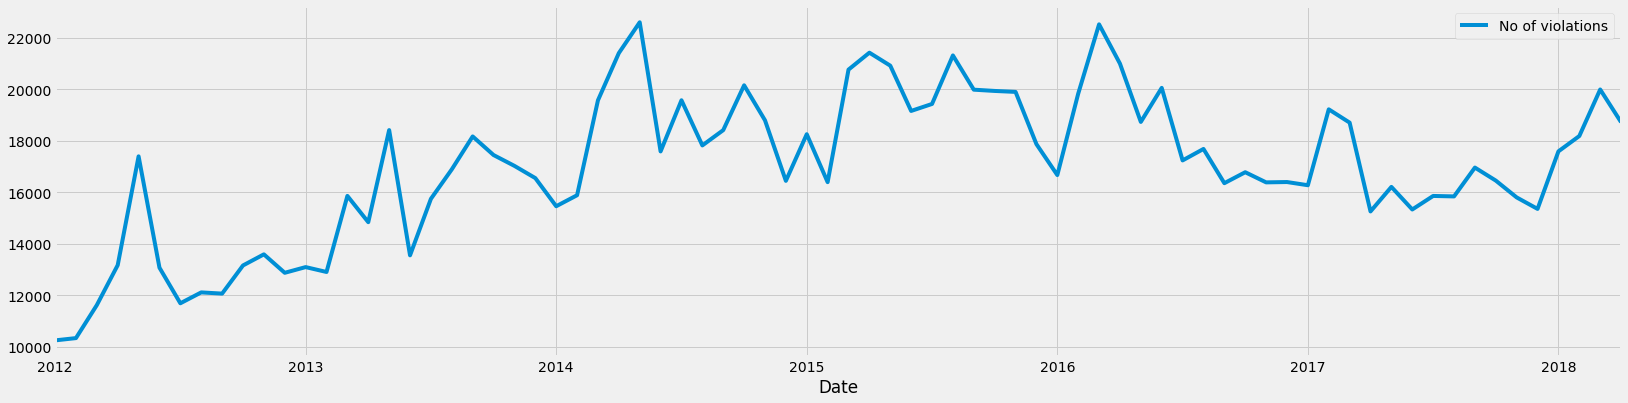

In [8]:
# The monthly trend of the belt violations till now
forecast_violation_month.plot(figsize=(25, 6))
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

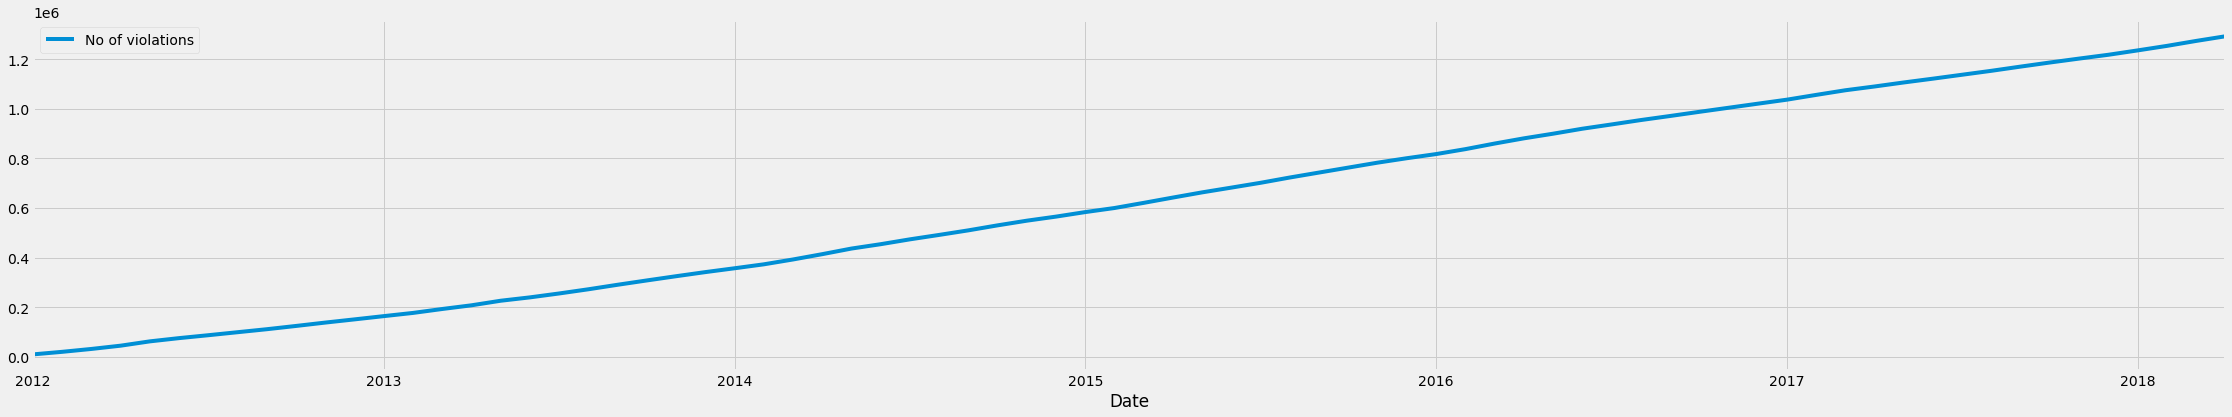

In [9]:
# The daily trend of the belt violations till now
forecast_violation_cumsum.plot(figsize=(35, 6))
plt.show()


In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p_m = d_m = q_m = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq_m = list(itertools.product(p_m, d_m, q_m))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq_m = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p_m, d_m, q_m))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq_m[1], seasonal_pdq_m[1]))
print('SARIMAX: {} x {}'.format(pdq_m[1], seasonal_pdq_m[2]))
print('SARIMAX: {} x {}'.format(pdq_m[2], seasonal_pdq_m[3]))
print('SARIMAX: {} x {}'.format(pdq_m[2], seasonal_pdq_m[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
# Finding parameters for the Seasonal ARIMA model, using grid search for hypterpameterization and model selection
# Grid searach is an iterative process of finding parameters, that inturn help to find optimal parameters 

warnings.filterwarnings("ignore") # specify to ignore warning messages

# This is to keep a track of minimum AIC value and record its parameters
min_value = 99999999
parameters = 0
sesonal_parameters = 0

for param in pdq_m:
    for param_seasonal in seasonal_pdq_m:
        try:
            mod_m = sm.tsa.statespace.SARIMAX(forecast_violation_cumsum,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results_m = mod_m.fit()
            
            if results_m.aic < min_value:
                min_value = results_m.aic
                parameters = param
                seasonal_parameters = param_seasonal
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results_m.aic))
        except:
            continue

print('################ Seasonal ARIMA Results ################')
print('Lowest AIC value: ', min_value)
print('Paramters: ',parameters)
print('Seasonal parameters: ', seasonal_parameters)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2242.535413254995
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:131596.16079437057
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1726.741301408807
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2298.3597967373266
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1667.6646973253014
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1581.8297693564743
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1210.3674040421222
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1188.1215624967263
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2161.45257174685
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:163307.58464468727
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1655.0544513763493
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2223.403558472616
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1856.8222966295275
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1800.777070120416
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1378.0055740272644
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1327.1659849443772
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1657.060659683845
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1355.0011820687919

In [12]:
# Fitting ARIMA model for the violation data set created using parameters from the previous step
mod = sm.tsa.statespace.SARIMAX(forecast_violation_cumsum,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Capturing the result by fitting the model
results = mod.fit()

print(results.summary().tables[1])



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9342      0.039     24.089      0.000       0.858       1.010
ma.L1         -0.5900      0.180     -3.285      0.001      -0.942      -0.238
ma.S.L12      -0.6626      0.227     -2.919      0.004      -1.107      -0.218
sigma2      3.386e+06    8.1e+05      4.178      0.000     1.8e+06    4.97e+06


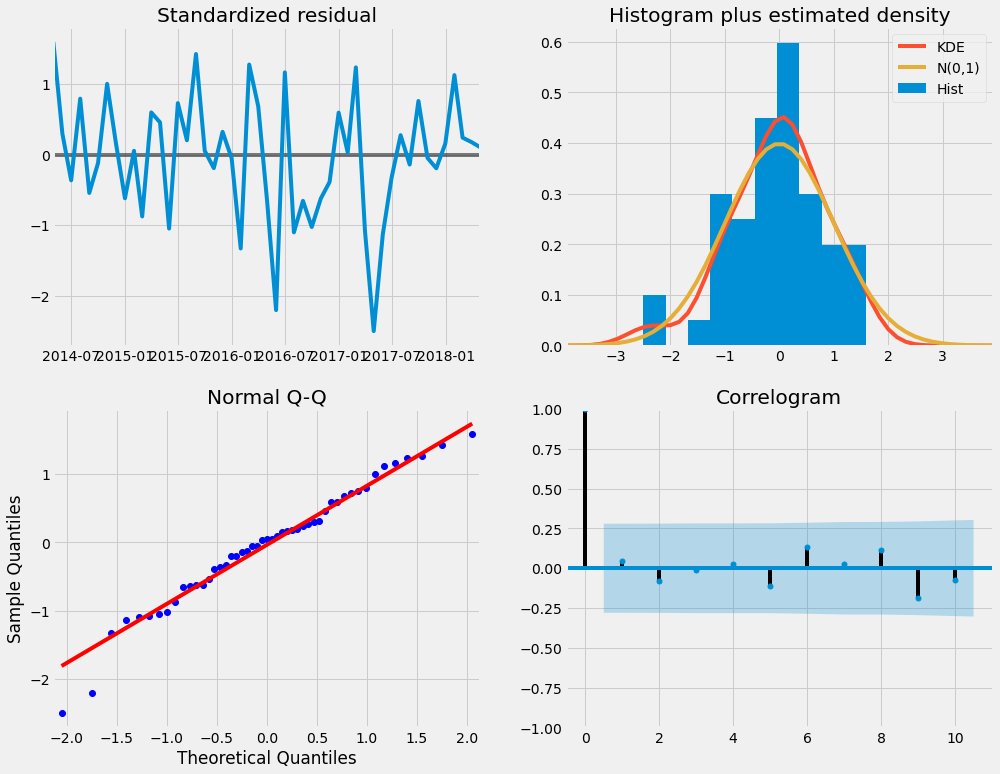

In [13]:
# The Diagnostic of the ARIMA model
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [14]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_ci = pred.conf_int()



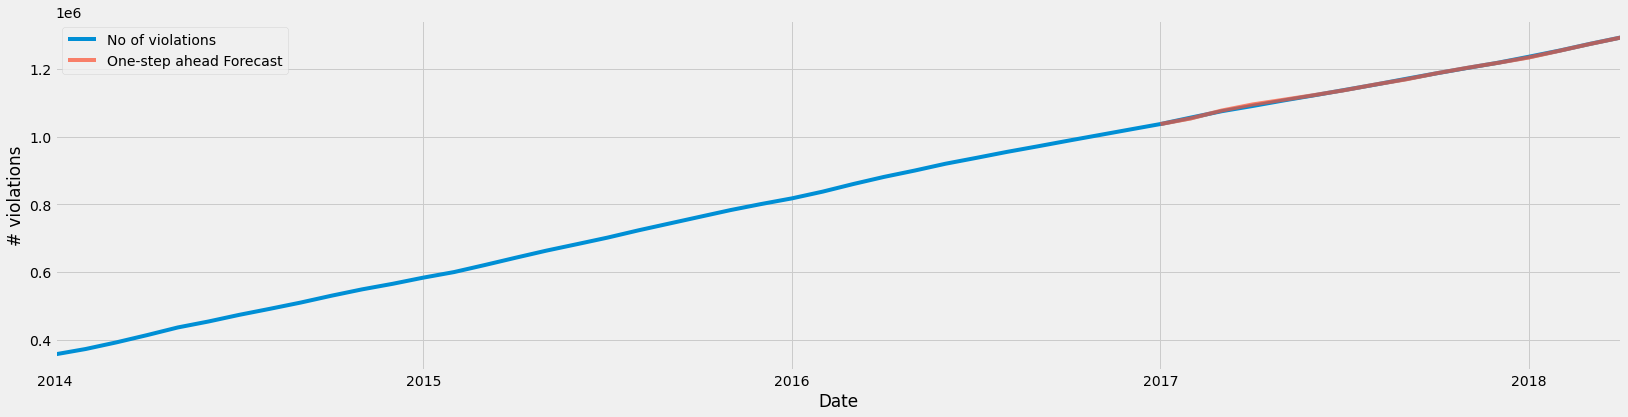

In [15]:
ax = forecast_violation_cumsum['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7,figsize=(25, 6))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('# violations')
plt.legend()

plt.show()




In [16]:
y_forecasted = pd.DataFrame(pred.predicted_mean)

y_truth = forecast_violation_cumsum['2017-01-31':]
y_truth = y_truth.astype(float)


# Compute the absolute percentage error
from math import sqrt
mse = np.mean(np.abs((y_truth.values - y_forecasted.values) / y_truth.values)) * 100
print('The Mean Absolute Percentage Error of our forecasts is', round(mse, 2))

# COmpute Mean square error
# mse = ((y_forecasted.values - y_truth.values) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Absolute Percentage Error of our forecasts is 0.1


In [18]:
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [19]:
# plot to show the future prediction upto 2 years
ax = forecast_violation_cumsum.plot(label='observed', figsize=(30, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('# violation')

plt.legend()
plt.show()
